# Word2Vec MovieQA Plots

In [1]:
import os
import math
import numpy as np
import tensorflow as tf
import string
import random
import zipfile
import pickle

from six.moves.urllib.request import urlretrieve
from collections import Counter, deque

In [2]:
%matplotlib inline
plot_files = os.listdir("plot/")

In [3]:
# Filenames
ext =  "plt_large"
ckpt_file = "w2v_%s.ckpt" % ext
id_map_file = "id_map_%s.pkl" % ext
embed_file = "embed_%s" % ext

## Build Vocab

In [4]:
exclude = '!"#$%&()*+,./:;<=>?@[\]^_`{|}~-' + "'"

vocab = Counter()
id_map = {'UNK': 0}

In [5]:
def tokenize_text(words, id_map):
    ''' Convert list of words into list of tokens/word-ids.
    Args:
      id_map: Hashmap from word to id. id of 0 is always 'UNK' unkown token.
    Ret: list of ints (ids)
    '''
    tokens = []
    for i, word in enumerate(words):
        id = 0 # 0 is UNK id
        if word in id_map:
            id = id_map[word]
        tokens.append(id)

    return tokens

## Load text8 data

In [6]:
text8 = []
with open("text8") as f:
    text8 = f.read().split()
    print text8[:10]

for word in text8:
    vocab[word]+=1


['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


## Load plots data

In [7]:
plots = []

for plot_file in plot_files:
    with open("plot/" + plot_file) as f:
        t = f.read().lower()
        plot_words = ''.join(ch if ch not in exclude else ' ' for ch in t).split() # Filter punctuation
        for i, word in enumerate(plot_words):
            vocab[word]+=1
    
    plots.append(plot_words)

## Set up Vocab

In [8]:
THRESH = 3

# Add all plot words above threshold to 
# vocab id map.
for plot in plots:
    for word in plot:
        if word not in id_map and vocab[word] > THRESH:
            id_map[word] = len(id_map)

common_words = vocab.most_common(60000)
# Add common words in text8 to vocab, up to the vocab size
for word, _ in common_words:
    '''if len(id_map) >= VOCAB_SIZE:
        break'''
    if word not in id_map:
        id_map[word] = len(id_map)


tokenized_text8 = tokenize_text(text8, id_map)
tk_plot = []
for plot in plots:
    tk_plot.extend(tokenize_text(plot, id_map))

In [9]:
def save_obj(obj, name ):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    print '%s saved' % name
save_obj(id_map, id_map_file)

VOCAB_SIZE = len(id_map)
print 'Vocab Size:', len(id_map)
print 'Common words cutoff', common_words[-1]
print tk_plot[:20]

id_map_plt_large.pkl saved
Vocab Size: 61273
Common words cutoff ('unenthusiastic', 6)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 2, 19]


## Batch Function

In [23]:
def getPairs(start_index, data, batch_size=128, wing_size=10):
    ''' start: 
        data:
        size: batch size
    '''
    index = start_index%len(data)
    batch_in = []
    batch_lbls = []
    window_size = wing_size*2+1
    
    context = [data[(index+offset)%len(data)] for offset in range(-1*wing_size, wing_size+1)]
    context = deque(context, maxlen=window_size)
    for i in range(batch_size):
        # Loop through words
        batch_in.append(data[index])
        batch_lbls.append(context)

        index = (index+1)%len(data)
        
        context.append(data[(index+wing_size)%len(data)])
        
    return np.array(batch_in), np.array(batch_lbls)[:,np.arange(window_size)!=wing_size]

def getBatch(batch_num, data, batch_size, wing_size=10):
    init = (batch_num*batch_size)%len(data)
    return getPairs(init, data, batch_size, wing_size)


## Build Graph

In [13]:
dim = 128 # number of dimensions of representation
vocab_size = len(id_map)
num_sampled = 15
batch_size = 128
window_size = 10

graph = tf.Graph()

with graph.as_default():
    word_ids = tf.placeholder(tf.int64, shape=[batch_size])
    labels = tf.placeholder(tf.int64, shape=[batch_size, window_size*2])
    embed = tf.Variable(tf.random_uniform([vocab_size, dim], -1, 1), name='center_rep')
    h1 = tf.nn.embedding_lookup(embed, word_ids)
    
    loss = 0
    
    with tf.device('/cpu:0'):
        for i in range(window_size*2):
            w = tf.Variable(tf.truncated_normal([vocab_size, dim], stddev=1.0 / math.sqrt(dim)), name='context_rep')
            b = tf.Variable(tf.zeros([vocab_size]))
            loss += tf.reduce_mean(tf.nn.sampled_softmax_loss(w, b, h1,  labels=labels[:,i:i+1], 
                                       num_sampled=num_sampled, num_classes=vocab_size))
        
    optimizer = tf.train.AdagradOptimizer(1).minimize(loss)
    saver = tf.train.Saver()
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embed), 1, keep_dims=True))
    norm_embeddings = embed/norm

## Run Training

In [24]:
num_steps = 100001

# Change this to the data you want to use!
#data = np.array(tokenized_text8) # or use tk_plot
data = np.array(tk_plot)
#data = np.array(tokenized_text8 + tk_plot)
i = 0
save_path = ""

# Session config
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True

In [29]:
loss_data = []

with tf.Session(graph=graph, config=config) as sess:
    # Initialize
    tf.initialize_all_variables().run()
    print "vars init."
    if os.path.isfile(ckpt_file):
        print("Loading from ckpt file")
        saver.restore(sess, ckpt_file)     
    
    # Run
    sum_l = 0
    print("Training")
    for step in range(num_steps):
        batch_in, batch_lbls = getBatch(i, data, batch_size, window_size)
            
        feed_dict = {word_ids: batch_in, labels: batch_lbls}
        _, l = sess.run([optimizer, loss], feed_dict=feed_dict)
        sum_l += l
        
        if step%4000 == 0 and step!=0:
            loss_data.append(sum_l/4000)
            print(str(step) + ": "+ str(sum_l/4000))
            sum_l=0
            if step%52000 == 0:
                save_path = saver.save(sess, ckpt_file)
            
        i+=1
    
    if os.path.isfile(ckpt_file):
        os.remove(ckpt_file)
    save_path = saver.save(sess, ckpt_file)
    embed = norm_embeddings.eval()
    print("fin")

vars init.
Loading from ckpt file
Training
4000: 15.6025659096
8000: 15.5395163552
12000: 15.38788473
16000: 15.3899014647
20000: 15.2302140957
24000: 15.1617580962
28000: 15.1017138184
32000: 15.0048243512
36000: 15.0198876333
40000: 14.7996203271
44000: 14.8726117412
48000: 14.7487612183
52000: 14.7260749243
56000: 14.69672919
60000: 14.5834545938
64000: 14.5582958412
68000: 14.4287796433
72000: 14.5626087142
76000: 14.3935490289
80000: 14.3658701371
84000: 14.3165020752
88000: 14.2751735709
92000: 14.2265152903
96000: 14.2476698765
100000: 14.2309624627
fin


In [30]:
np.savez(embed_file, embed = embed)

In [27]:
os.path.getsize(save_path)

1327429692

In [18]:
from matplotlib import pylab
from sklearn.manifold import TSNE
num_points = 400
common_words = [x[0] for x in vocab.most_common(num_points)]
common_indexes = []
for i in range(num_points):
    common_indexes.append(id_map[common_words[i]])
common_indexes = np.array(common_indexes)

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(embed[400:400+num_points+1, :])
#two_d_embeddings = tsne.fit_transform(embed[common_indexes, :])

ValueError: array must not contain infs or NaNs

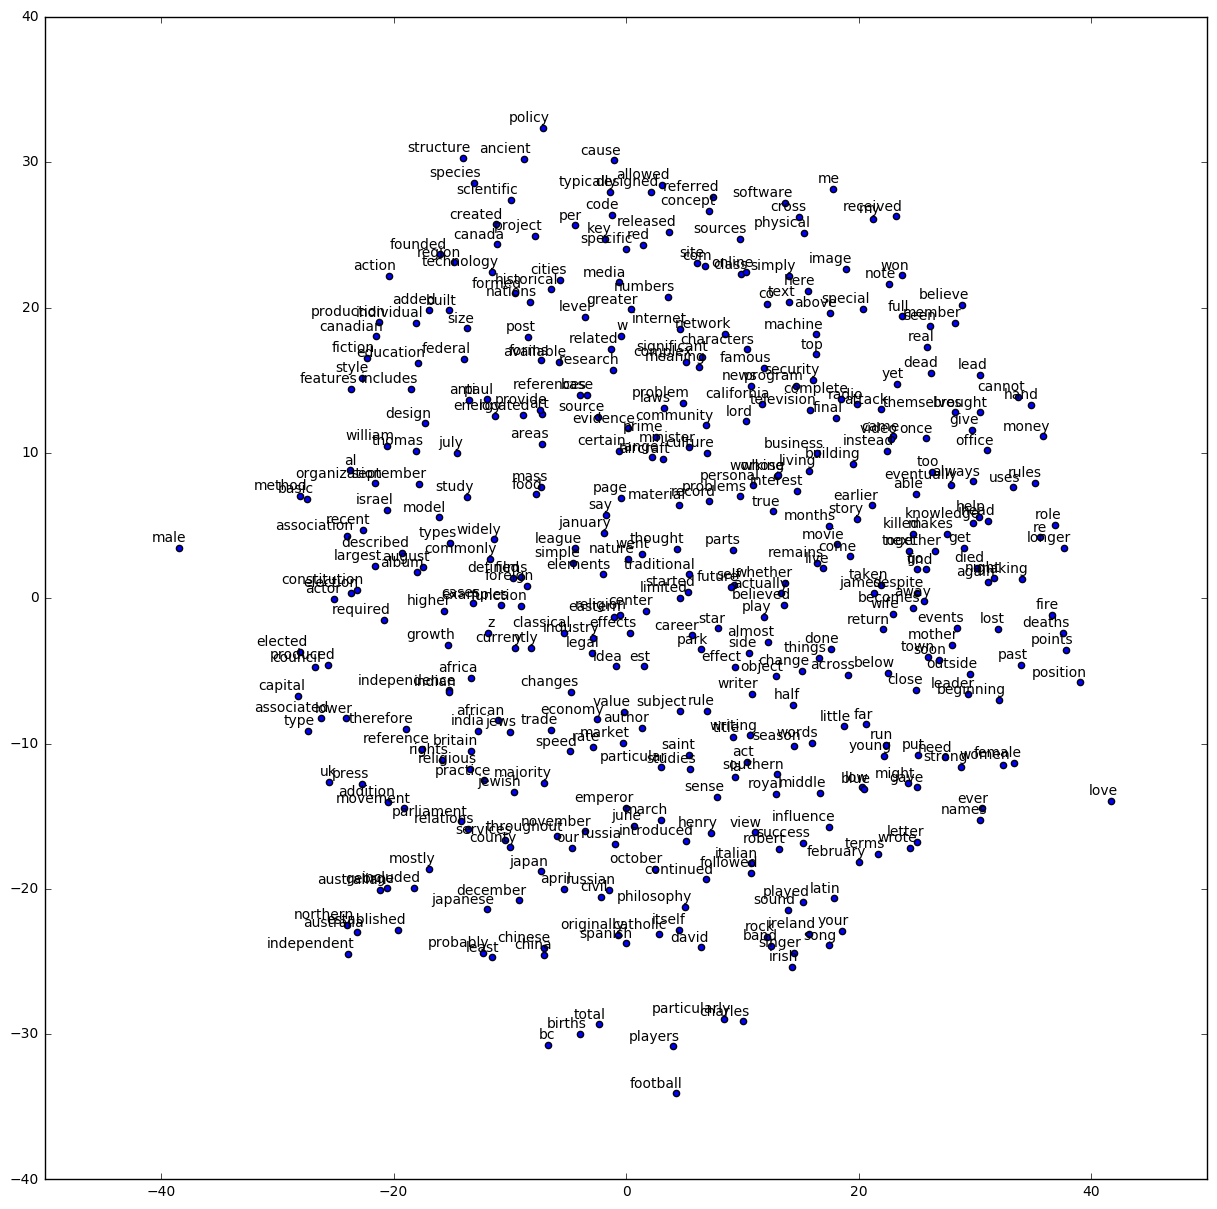

In [52]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

reverse_dictionary = dict(zip(id_map.values(), id_map.keys())) 
words = [reverse_dictionary[i] for i in range(400, 400+num_points+1)]
plot(two_d_embeddings, words)

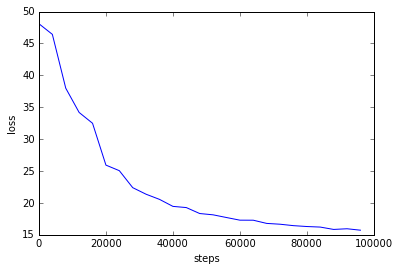

In [28]:
pylab.ylabel("loss")
pylab.xlabel("steps")
pylab.plot(np.arange(1,num_steps-1, 4001), loss_data)

In [22]:
embed.shape

(61273, 128)